In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("="*70)
print(" TELCO CUSTOMER CHURN - EXPLORATORY DATA ANALYSIS")
print("="*70)

 TELCO CUSTOMER CHURN - EXPLORATORY DATA ANALYSIS


# 1. Data loading and Initial inspection

In [2]:
file_path = '/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

print("\n[1] DATASET OVERVIEW")
print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns")
print("\nFirst 5 rows:")
print(df.head())

print("\n[2] DATA TYPES AND MISSING VALUES")
df.info()


[1] DATASET OVERVIEW
Dataset Shape: 7043 rows, 21 columns

First 5 rows:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...          

# 2. Data cleaning

In [3]:
# Check for missing values
print("Initial missing values:")
print(df.isnull().sum().sum(), "total missing values")

Initial missing values:
0 total missing values


In [4]:
# Convert TotalCharges to numeric (blanks become NaN)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
missing_total_charges = df['TotalCharges'].isnull().sum()
print(f"\nTotalCharges has {missing_total_charges} missing values (blank strings)")


TotalCharges has 11 missing values (blank strings)


In [5]:
# Analyze missing TotalCharges rows
if missing_total_charges > 0:
    print("\nCustomers with missing TotalCharges:")
    print(df[df['TotalCharges'].isnull()][['tenure', 'MonthlyCharges', 'TotalCharges']].head())
    print(f"All have tenure = {df[df['TotalCharges'].isnull()]['tenure'].unique()}")
    print("→ These are new customers (0 months tenure), filling with 0")
    df['TotalCharges'].fillna(0, inplace=True)


Customers with missing TotalCharges:
      tenure  MonthlyCharges  TotalCharges
488        0           52.55           NaN
753        0           20.25           NaN
936        0           80.85           NaN
1082       0           25.75           NaN
1340       0           56.05           NaN
All have tenure = [0]
→ These are new customers (0 months tenure), filling with 0


In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")


Duplicate rows: 0


In [7]:
# Drop customerID (not useful for modeling)
df.drop('customerID', axis=1, inplace=True)
print(f"\nDropped 'customerID' column")
print(f"Final shape: {df.shape}")


Dropped 'customerID' column
Final shape: (7043, 20)


# 3. Target variable analysis - churn

In [8]:
churn_counts = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print(f"Churn Distribution:")
print(f"  No:  {churn_counts['No']:4d} ({churn_pct['No']:.2f}%)")
print(f"  Yes: {churn_counts['Yes']:4d} ({churn_pct['Yes']:.2f}%)")
print(f"\n  Class Imbalance Ratio: {churn_pct['No']/churn_pct['Yes']:.2f}:1")
print("   → Will need to handle imbalance (class weights/SMOTE)")

Churn Distribution:
  No:  5174 (73.46%)
  Yes: 1869 (26.54%)

  Class Imbalance Ratio: 2.77:1
   → Will need to handle imbalance (class weights/SMOTE)


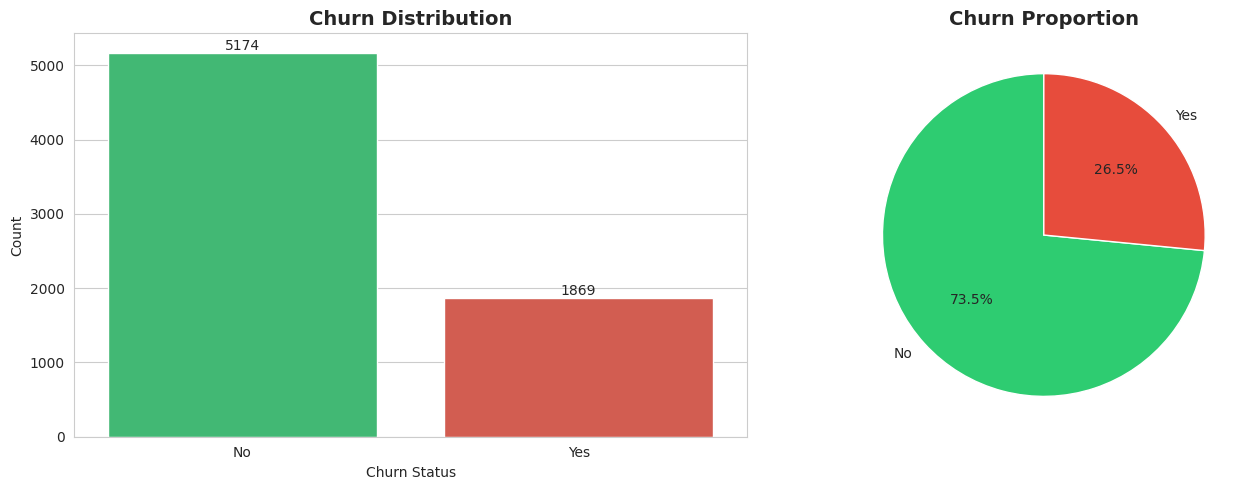

In [9]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(x='Churn', data=df, palette=['#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Churn Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Count')
for container in axes[0].containers:
    axes[0].bar_label(container)

# Pie chart
colors = ['#2ecc71', '#e74c3c']
axes[1].pie(churn_counts, labels=churn_counts.index, autopct='%1.1f%%', 
            colors=colors, startangle=90)
axes[1].set_title('Churn Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/01_churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Numerical features analysis

In [10]:
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

print("\nDescriptive Statistics:")
print(df[num_cols].describe())


Descriptive Statistics:
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2279.734304
std      24.559481       30.090047   2266.794470
min       0.000000       18.250000      0.000000
25%       9.000000       35.500000    398.550000
50%      29.000000       70.350000   1394.550000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000



4.1 Histograms of Numerical Features:


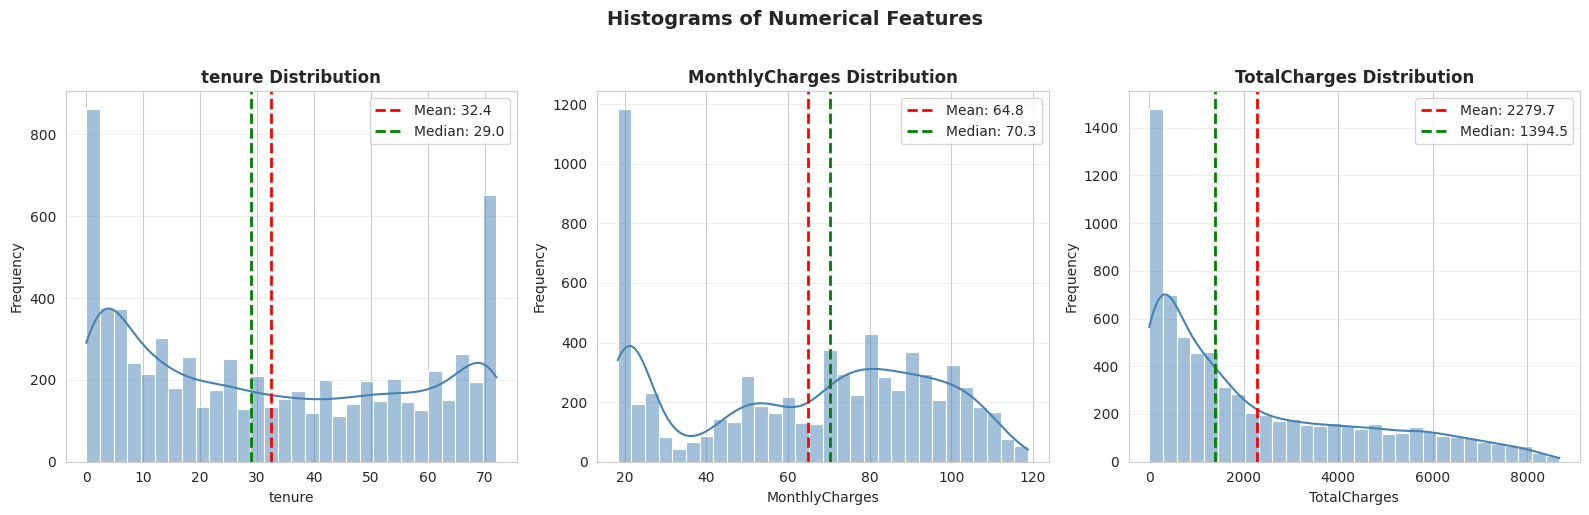

   ✓ Saved: 02a_histograms_numerical.png


In [11]:
print("\n4.1 Histograms of Numerical Features:")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, color='steelblue', bins=30, ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add statistics text
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
    axes[idx].axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
    axes[idx].legend()

plt.suptitle('Histograms of Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/kaggle/working/02a_histograms_numerical.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✓ Saved: 02a_histograms_numerical.png")


4.2 Box Plots of Numerical Features by Churn:


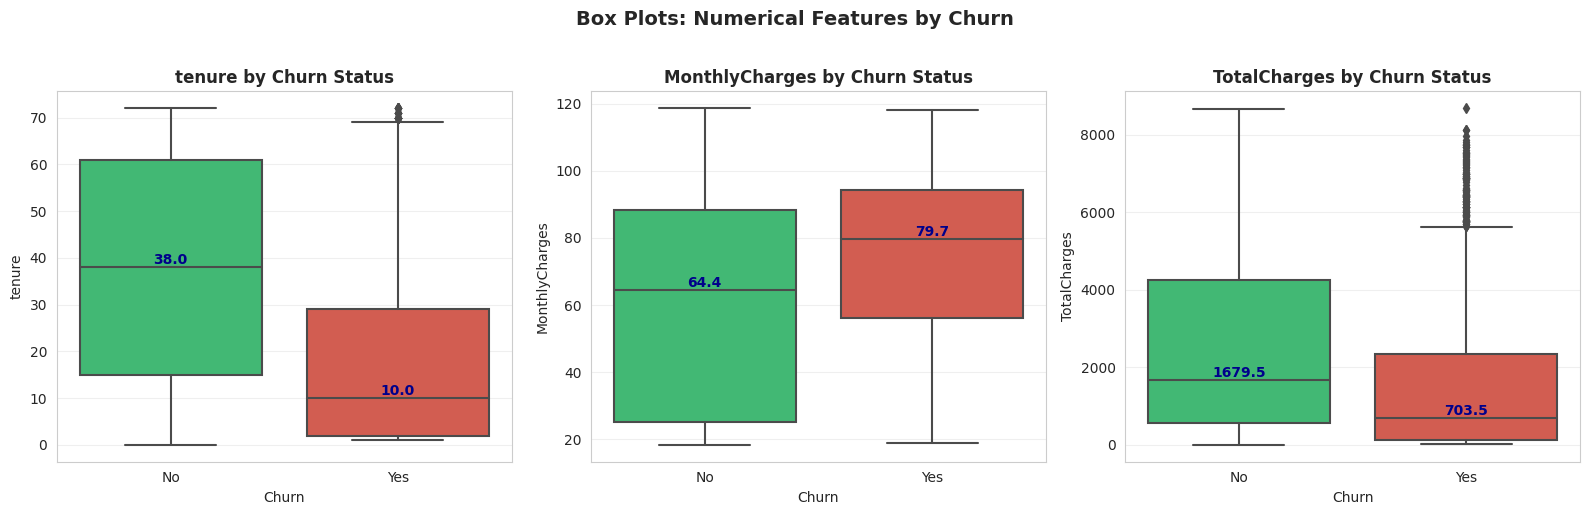

   ✓ Saved: 02b_boxplots_numerical.png


In [12]:
print("\n4.2 Box Plots of Numerical Features by Churn:")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, col in enumerate(num_cols):
    sns.boxplot(x='Churn', y=col, data=df, palette=['#2ecc71', '#e74c3c'], ax=axes[idx])
    axes[idx].set_title(f'{col} by Churn Status', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add median values as text
    medians = df.groupby('Churn')[col].median()
    for i, (churn, median) in enumerate(medians.items()):
        axes[idx].text(i, median, f'{median:.1f}', 
                      ha='center', va='bottom', fontweight='bold', color='darkblue')

plt.suptitle('Box Plots: Numerical Features by Churn', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('/kaggle/working/02b_boxplots_numerical.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✓ Saved: 02b_boxplots_numerical.png")


4.3 Combined View - Histograms with Churn Overlay + Box Plots:


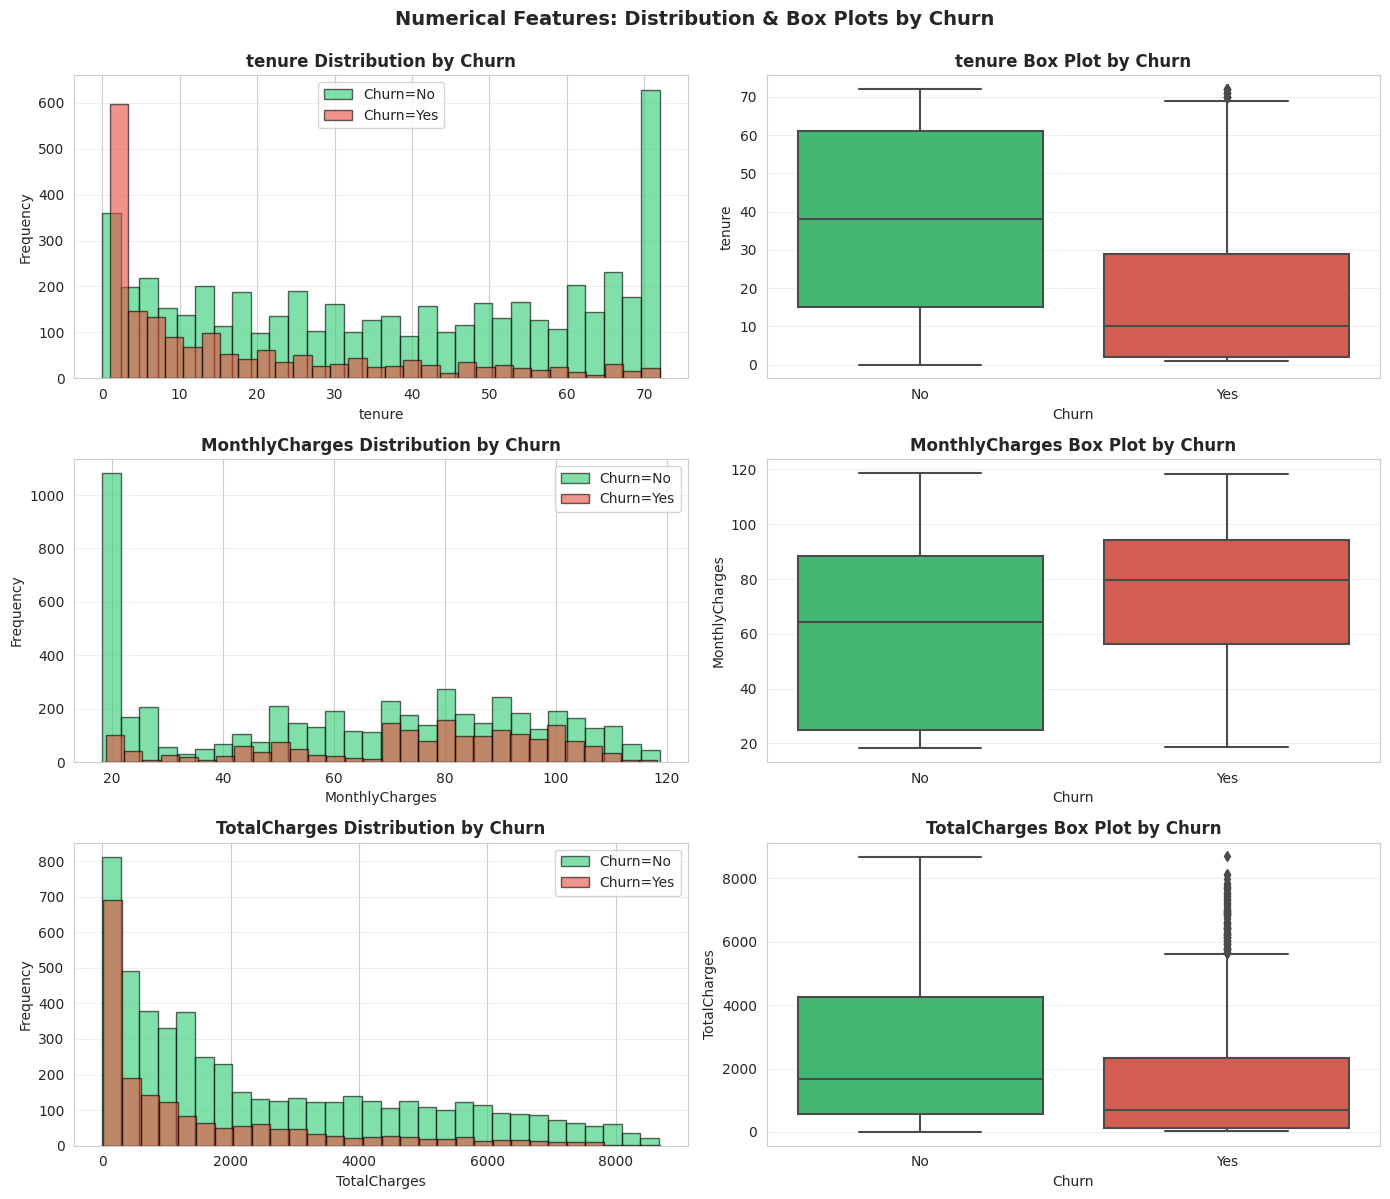

   ✓ Saved: 02_numerical_features.png


In [13]:
print("\n4.3 Combined View - Histograms with Churn Overlay + Box Plots:")
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

for idx, col in enumerate(num_cols):
    # Left: Histogram with churn overlay
    for churn_val in ['No', 'Yes']:
        data = df[df['Churn'] == churn_val][col]
        color = '#2ecc71' if churn_val == 'No' else '#e74c3c'
        axes[idx, 0].hist(data, alpha=0.6, label=f'Churn={churn_val}', 
                         bins=30, color=color, edgecolor='black')
    axes[idx, 0].set_title(f'{col} Distribution by Churn', fontsize=12, fontweight='bold')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    axes[idx, 0].legend()
    axes[idx, 0].grid(axis='y', alpha=0.3)
    
    # Right: Box plot
    sns.boxplot(x='Churn', y=col, data=df, palette=['#2ecc71', '#e74c3c'], ax=axes[idx, 1])
    axes[idx, 1].set_title(f'{col} Box Plot by Churn', fontsize=12, fontweight='bold')
    axes[idx, 1].set_ylabel(col)
    axes[idx, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Numerical Features: Distribution & Box Plots by Churn', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/02_numerical_features.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✓ Saved: 02_numerical_features.png")

In [14]:
# Statistical comparison
print("\nNumerical Features by Churn:")
print(df.groupby('Churn')[num_cols].mean())

print("\n Key Observations:")
print("   • Tenure: Churners have LOWER tenure (median ~10 vs ~38 months)")
print("   • MonthlyCharges: Churners pay MORE per month (~$75 vs ~$62)")
print("   • TotalCharges: Churners have LOWER total (~$1500 vs ~$2500)")
print("   → Short-term customers paying high monthly fees are at risk!")


Numerical Features by Churn:
          tenure  MonthlyCharges  TotalCharges
Churn                                         
No     37.569965       61.265124   2549.911442
Yes    17.979133       74.441332   1531.796094

 Key Observations:
   • Tenure: Churners have LOWER tenure (median ~10 vs ~38 months)
   • MonthlyCharges: Churners pay MORE per month (~$75 vs ~$62)
   • TotalCharges: Churners have LOWER total (~$1500 vs ~$2500)
   → Short-term customers paying high monthly fees are at risk!


# 5. Categorical features analysis

In [15]:
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 
            'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
            'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 
            'Contract', 'PaperlessBilling', 'PaymentMethod']

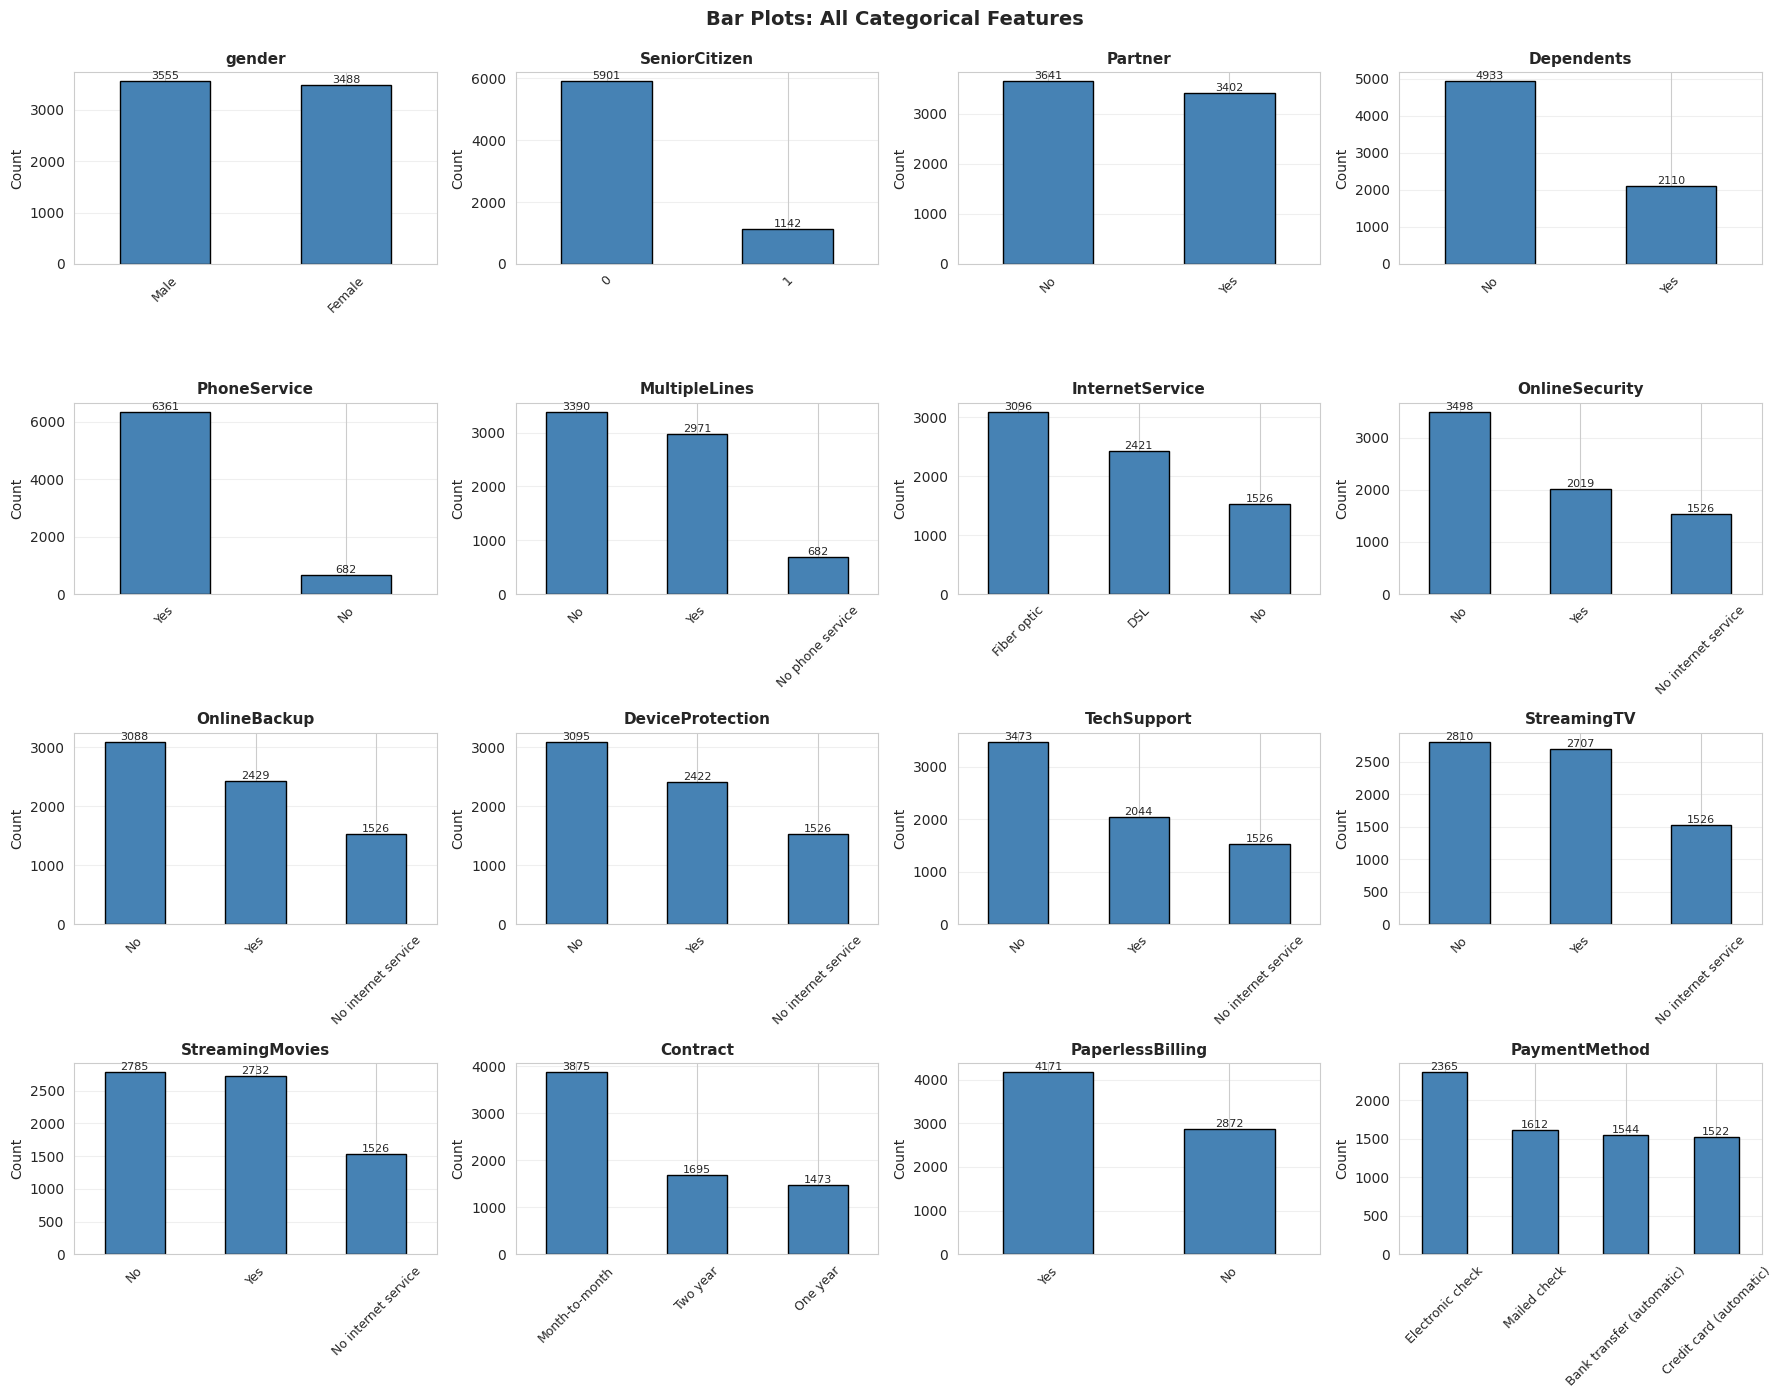

   ✓ Saved: 03a_barplots_categorical.png


In [16]:
# Calculate number of rows needed
n_features = len(cat_cols)
n_cols_grid = 4
n_rows_grid = (n_features + n_cols_grid - 1) // n_cols_grid

fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(18, n_rows_grid * 3.5))
axes = axes.flatten()

for idx, col in enumerate(cat_cols):
    counts = df[col].value_counts()
    
    # Create bar plot
    counts.plot(kind='bar', ax=axes[idx], color='steelblue', edgecolor='black')
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Add count labels on bars
    for container in axes[idx].containers:
        axes[idx].bar_label(container, fmt='%d', fontsize=8)

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Bar Plots: All Categorical Features', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/03a_barplots_categorical.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✓ Saved: 03a_barplots_categorical.png")

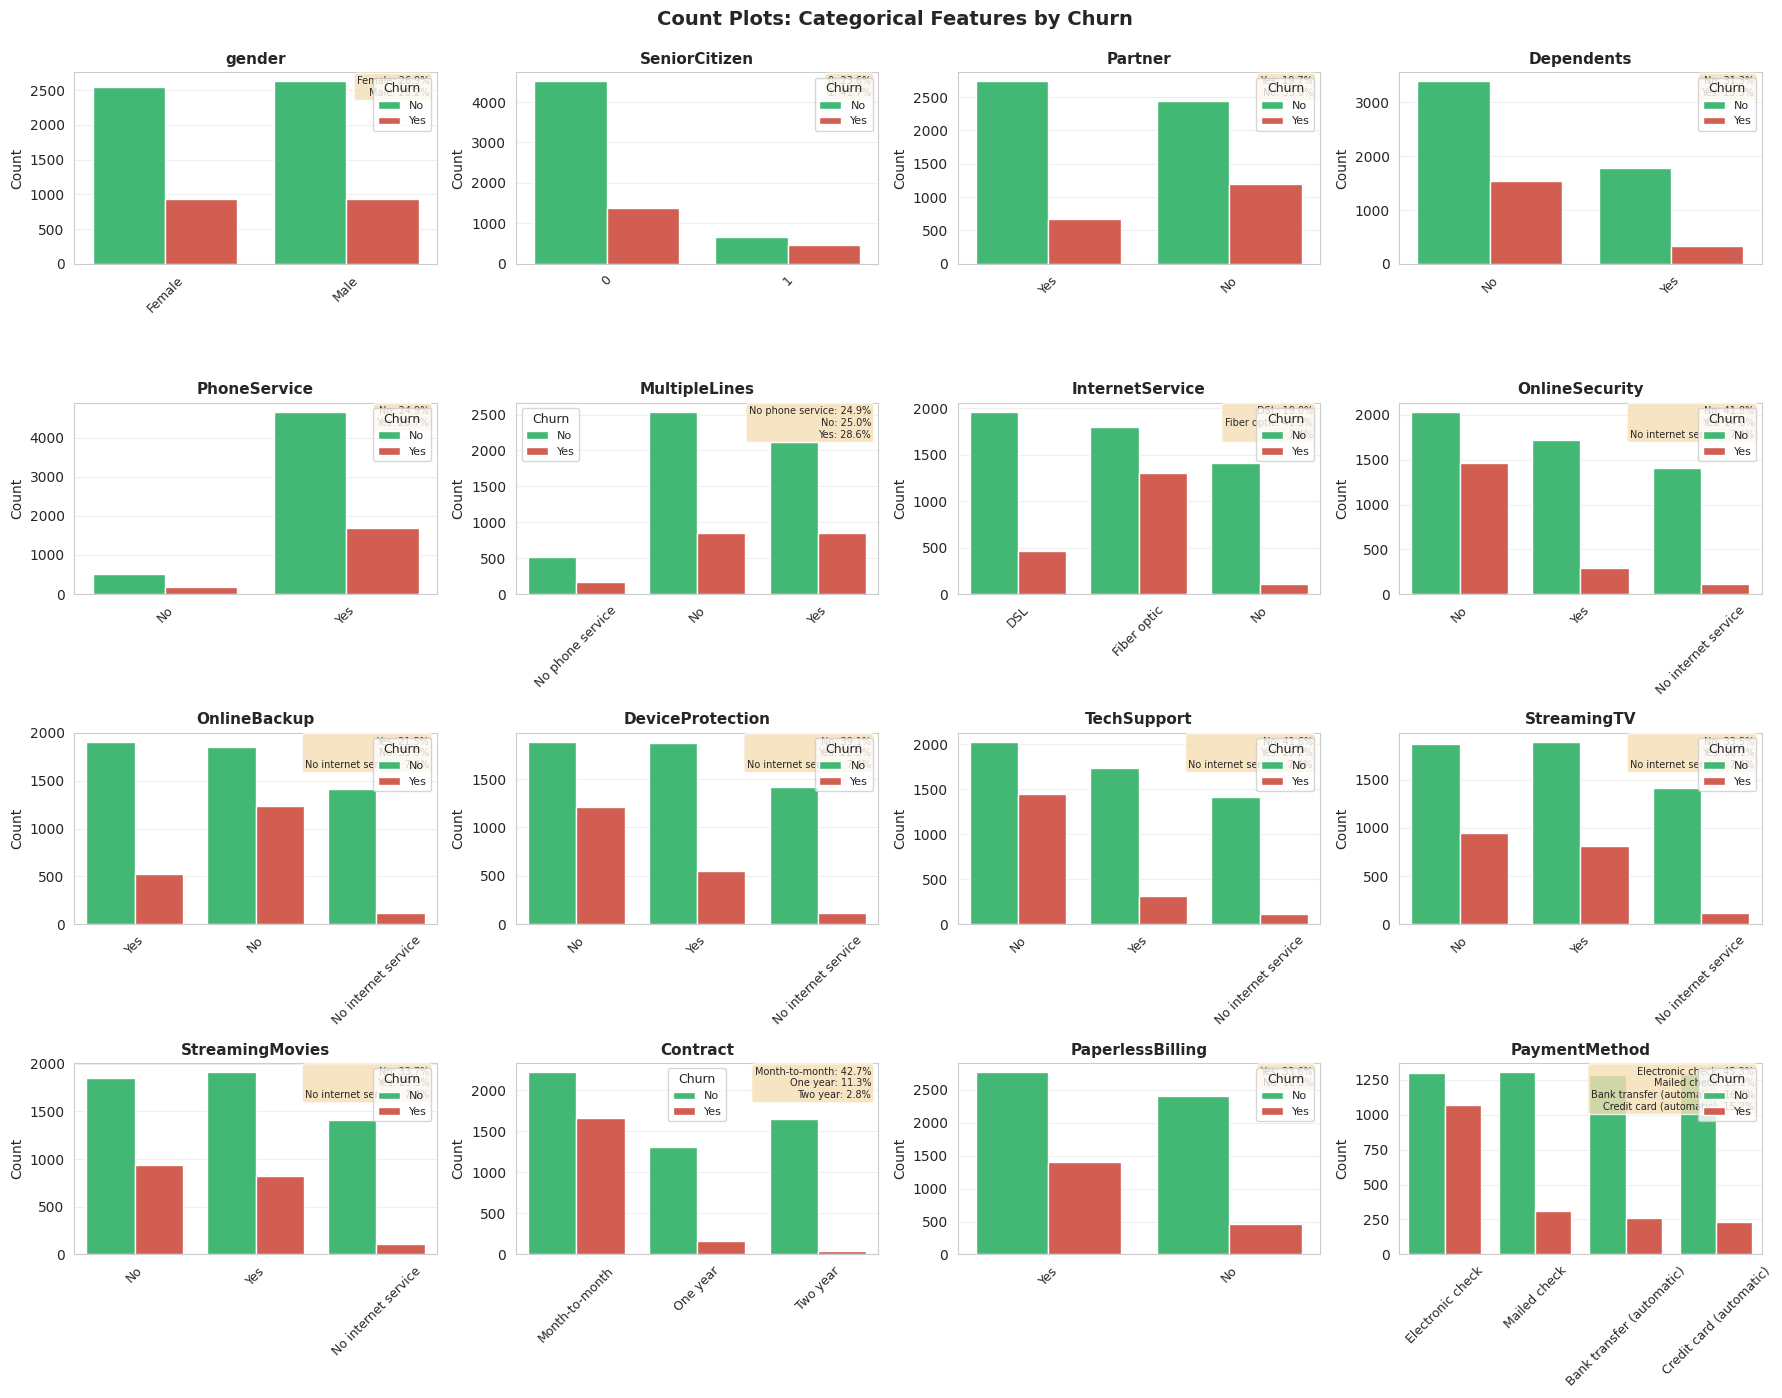

   ✓ Saved: 03b_countplots_by_churn.png


In [17]:
fig, axes = plt.subplots(n_rows_grid, n_cols_grid, figsize=(18, n_rows_grid * 3.5))
axes = axes.flatten()

for idx, col in enumerate(cat_cols):
    # Create count plot with churn
    sns.countplot(x=col, hue='Churn', data=df, palette=['#2ecc71', '#e74c3c'], ax=axes[idx])
    axes[idx].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel('')
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    axes[idx].legend(title='Churn', fontsize=8, title_fontsize=9)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # Calculate and display churn rates
    churn_rate_text = []
    for category in df[col].unique():
        subset = df[df[col] == category]
        churn_rate = (subset['Churn'] == 'Yes').mean() * 100
        churn_rate_text.append(f"{category}: {churn_rate:.1f}%")
    
    # Add churn rate as text (only for features with few categories)
    if len(df[col].unique()) <= 4:
        text = '\n'.join(churn_rate_text)
        axes[idx].text(0.98, 0.98, text, transform=axes[idx].transAxes,
                      fontsize=7, va='top', ha='right',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('Count Plots: Categorical Features by Churn', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('/kaggle/working/03b_countplots_by_churn.png', dpi=300, bbox_inches='tight')
plt.show()

print("   ✓ Saved: 03b_countplots_by_churn.png")

# 6. Key insights - churn drivers

In [18]:
# Contract type impact
contract_churn = df.groupby('Contract')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
print("\n1. CONTRACT TYPE (Strongest predictor):")
for contract, rate in contract_churn.items():
    print(f"   • {contract:20s}: {rate:5.1f}% churn rate")


1. CONTRACT TYPE (Strongest predictor):
   • Month-to-month      :  42.7% churn rate
   • One year            :  11.3% churn rate
   • Two year            :   2.8% churn rate


In [19]:
# Internet service impact
internet_churn = df.groupby('InternetService')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
print("\n2. INTERNET SERVICE:")
for service, rate in internet_churn.items():
    print(f"   • {service:20s}: {rate:5.1f}% churn rate")


2. INTERNET SERVICE:
   • DSL                 :  19.0% churn rate
   • Fiber optic         :  41.9% churn rate
   • No                  :   7.4% churn rate


In [20]:
# Add-on services (no protection)
no_security = df[df['OnlineSecurity'] == 'No']['Churn'].apply(lambda x: x == 'Yes').mean() * 100
no_backup = df[df['OnlineBackup'] == 'No']['Churn'].apply(lambda x: x == 'Yes').mean() * 100
no_support = df[df['TechSupport'] == 'No']['Churn'].apply(lambda x: x == 'Yes').mean() * 100

print("\n3. ADD-ON SERVICES (Lack of):")
print(f"   • No Online Security:  {no_security:.1f}% churn rate")
print(f"   • No Online Backup:    {no_backup:.1f}% churn rate")
print(f"   • No Tech Support:     {no_support:.1f}% churn rate")


3. ADD-ON SERVICES (Lack of):
   • No Online Security:  41.8% churn rate
   • No Online Backup:    39.9% churn rate
   • No Tech Support:     41.6% churn rate


In [21]:
# Senior citizens
senior_churn = df.groupby('SeniorCitizen')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
print("\n4. DEMOGRAPHICS:")
print(f"   • Seniors (1):         {senior_churn[1]:.1f}% churn rate")
print(f"   • Non-Seniors (0):     {senior_churn[0]:.1f}% churn rate")


4. DEMOGRAPHICS:
   • Seniors (1):         41.7% churn rate
   • Non-Seniors (0):     23.6% churn rate


# 7. Correlation Analysis

In [22]:
# Encode for correlation
df_encoded = df.copy()
le = LabelEncoder()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

In [23]:
# Calculate correlations with Churn
corr_with_churn = df_encoded.corr()['Churn'].sort_values(ascending=False)
print("\nTop 10 Features Correlated with Churn:")
print(corr_with_churn.head(11)[1:])  # Exclude Churn itself

print("\nBottom 5 Features (Negative Correlation):")
print(corr_with_churn.tail(5))


Top 10 Features Correlated with Churn:
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
InternetService    -0.047291
Name: Churn, dtype: float64

Bottom 5 Features (Negative Correlation):
TotalCharges     -0.198324
TechSupport      -0.282492
OnlineSecurity   -0.289309
tenure           -0.352229
Contract         -0.396713
Name: Churn, dtype: float64


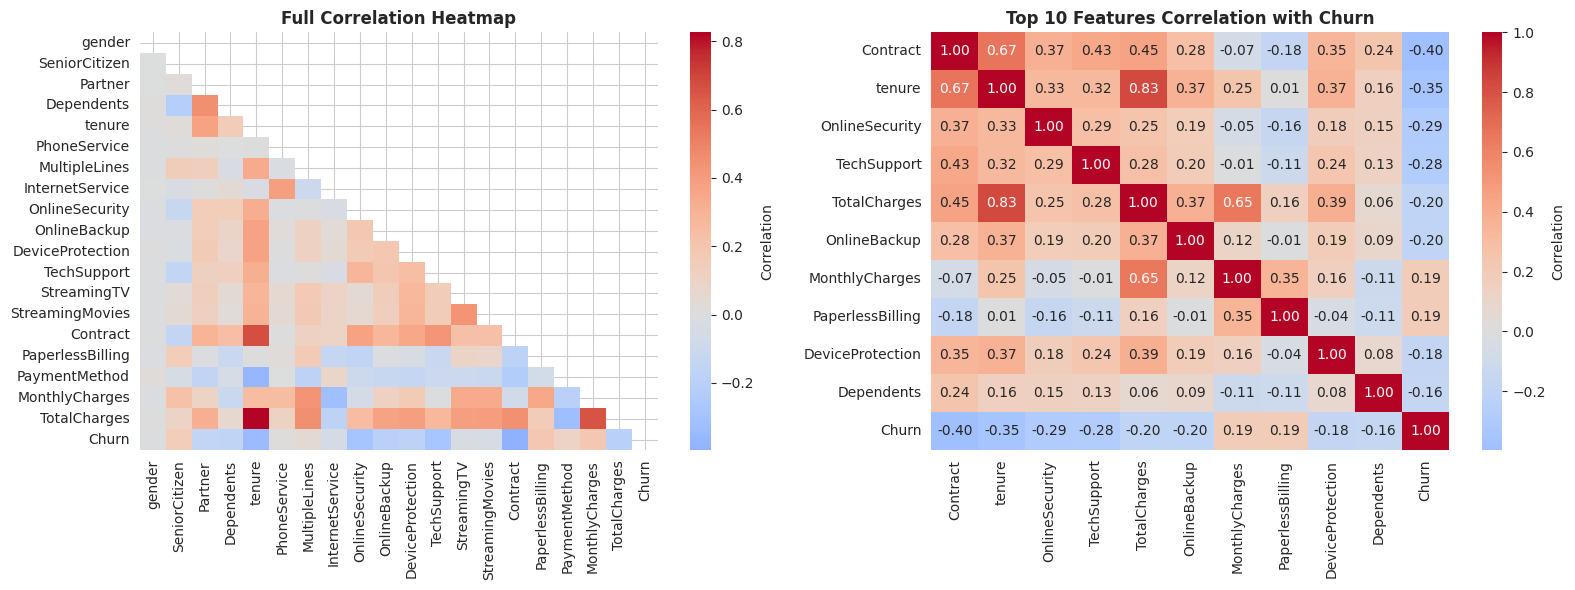

In [24]:
# Correlation heatmap for numerical features
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Full correlation heatmap
corr_matrix = df_encoded.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0, 
            ax=axes[0], cbar_kws={'label': 'Correlation'})
axes[0].set_title('Full Correlation Heatmap', fontsize=12, fontweight='bold')

# Top features with Churn
top_features = corr_with_churn.abs().sort_values(ascending=False).head(11).index[1:]
corr_subset = df_encoded[list(top_features) + ['Churn']].corr()
sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            ax=axes[1], cbar_kws={'label': 'Correlation'})
axes[1].set_title('Top 10 Features Correlation with Churn', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('/kaggle/working/06_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. Advanced Insights - Feature Combinations

In [25]:
# Tenure segments
df['TenureBin'] = pd.cut(df['tenure'], bins=[0, 12, 36, 72], labels=['0-12m', '12-36m', '36m+'])
tenure_churn = df.groupby('TenureBin')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

print("\nChurn Rate by Tenure Segments:")
for segment, rate in tenure_churn.items():
    print(f"   • {segment:10s}: {rate:5.1f}% churn rate")


Churn Rate by Tenure Segments:
   • 0-12m     :  47.7% churn rate
   • 12-36m    :  25.5% churn rate
   • 36m+      :  11.9% churn rate


In [26]:
# Monthly charges bins
df['ChargesBin'] = pd.cut(df['MonthlyCharges'], bins=[0, 35, 70, 120], labels=['Low', 'Medium', 'High'])
charges_churn = df.groupby('ChargesBin')['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)

print("\nChurn Rate by Monthly Charges:")
for segment, rate in charges_churn.items():
    print(f"   • {segment:10s}: {rate:5.1f}% churn rate")


Churn Rate by Monthly Charges:
   • Low       :  10.9% churn rate
   • Medium    :  23.9% churn rate
   • High      :  35.4% churn rate


In [27]:
# High-risk profile
high_risk = df[(df['tenure'] < 12) & (df['Contract'] == 'Month-to-month') & 
               (df['MonthlyCharges'] > 70)]
high_risk_churn = (high_risk['Churn'] == 'Yes').mean() * 100

print(f"\n HIGH-RISK PROFILE:")
print(f"   Customers with: tenure < 12 months + Month-to-month + High charges")
print(f"   Churn Rate: {high_risk_churn:.1f}%")
print(f"   Count: {len(high_risk)} customers ({len(high_risk)/len(df)*100:.1f}% of total)")


 HIGH-RISK PROFILE:
   Customers with: tenure < 12 months + Month-to-month + High charges
   Churn Rate: 69.5%
   Count: 814 customers (11.6% of total)


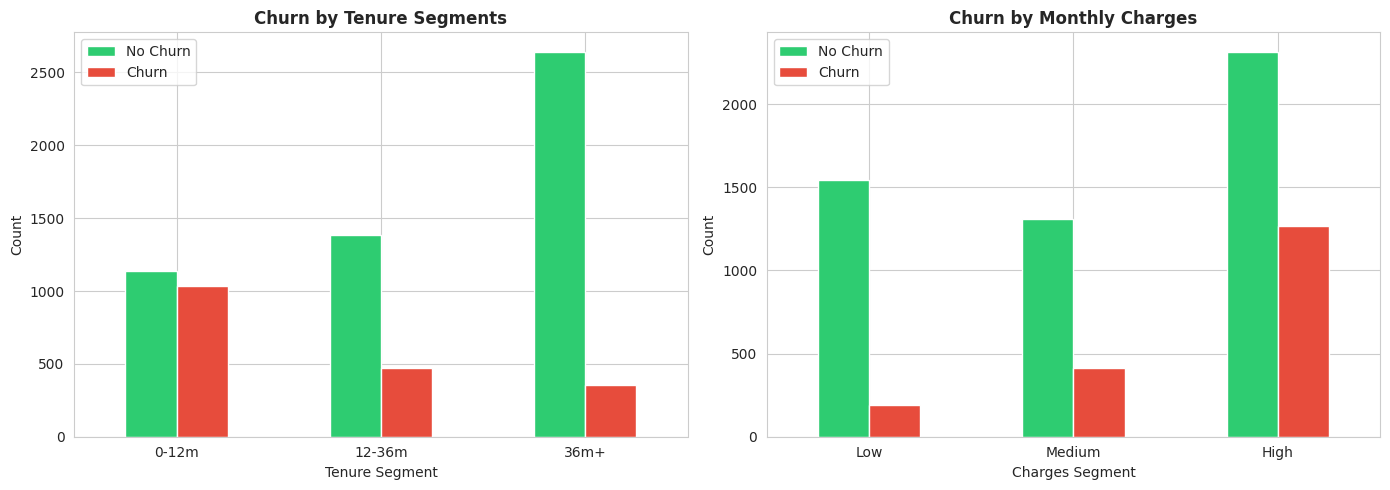

In [28]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tenure bins
tenure_data = df.groupby(['TenureBin', 'Churn']).size().unstack(fill_value=0)
tenure_data.plot(kind='bar', stacked=False, color=['#2ecc71', '#e74c3c'], ax=axes[0])
axes[0].set_title('Churn by Tenure Segments', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Tenure Segment')
axes[0].set_ylabel('Count')
axes[0].legend(['No Churn', 'Churn'])
axes[0].tick_params(axis='x', rotation=0)

# Charges bins
charges_data = df.groupby(['ChargesBin', 'Churn']).size().unstack(fill_value=0)
charges_data.plot(kind='bar', stacked=False, color=['#2ecc71', '#e74c3c'], ax=axes[1])
axes[1].set_title('Churn by Monthly Charges', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Charges Segment')
axes[1].set_ylabel('Count')
axes[1].legend(['No Churn', 'Churn'])
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('/kaggle/working/07_segments.png', dpi=300, bbox_inches='tight')
plt.show()